## 1. Import Libraries

In [1]:
# Ignore warnings
import warnings
warnings.simplefilter(action='ignore')

# Install Prerequisites
# import sys
# !{sys.executable} -m pip install scikit-learn scikit-surprise
# !pip install git+https://github.com/gbolmier/funk-svd

# Exploratory Data Analysis
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Data Preprocessing
import random
from time import time
import cufflinks as cf
import comet_ml
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
from sklearn.preprocessing import StandardScaler
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
from datetime import datetime

# Models
from surprise import Reader, Dataset
from surprise import SVD, NormalPredictor, BaselineOnly, NMF, SlopeOne, CoClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

# Performance Evaluation
from surprise import accuracy
from sklearn.metrics import mean_squared_error
from surprise.model_selection import GridSearchCV, cross_validate, train_test_split

# Display
%matplotlib inline
sns.set(font_scale=1)
sns.set_style("white")
pd.set_option('display.max_columns', 37)

## 2. Connecting to Comet

In [2]:
# Prject workspace linked to Comet experiment for version control
from comet_ml import Experiment

experiment = Experiment(
    api_key="F3rSD8MTRVMEXv1vtpSFsaw9j",
    project_name="team-6-unsupervised-learning",
    workspace="gudani",
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in 'C:\\Users\\MAHHEMBE\\Downloads\\explore\\unsupervised\\team_6\\New folder' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/gudani/team-6-unsupervised-learning/86d0dfcc5a934a82b8c3dfe908f4b740



## 3. Load Dataset

In [3]:
train_df=pd.read_csv('E:/explore/unsupervised/edsa-movie-recommendation-wilderness/train.csv')
test_df=pd.read_csv('E:/explore/unsupervised/edsa-movie-recommendation-wilderness/test.csv')
movies_df=pd.read_csv('E:/explore/unsupervised/edsa-movie-recommendation-wilderness/movies.csv')
imdb_df=pd.read_csv('E:/explore/unsupervised/edsa-movie-recommendation-wilderness/imdb_data.csv')
g_scores_df=pd.read_csv('E:/explore/unsupervised/edsa-movie-recommendation-wilderness/genome_scores.csv')
g_tags_df=pd.read_csv('E:/explore/unsupervised/edsa-movie-recommendation-wilderness/genome_tags.csv')
links_df=pd.read_csv('E:/explore/unsupervised/edsa-movie-recommendation-wilderness/links.csv')
tags_df=pd.read_csv('E:/explore/unsupervised/edsa-movie-recommendation-wilderness/tags.csv')

### Feature Description

**Numeric**
* **budget:** - (continuous) dollar cost of production of the movie.
* **rating:** - (discrete) users rating of a movie from. **TARGET**
* **relevance:** - (continuous) measure (0-1) of the relevance of a genome tag to the movie, where 1 impies 100% relevance.
* **runtime:** - (continuos) movie duration in minutes.
* **timestamp:** - (continuous) the time at which a user rated the movie.


**Categorical**
* **director:** - (nominal) the person who controls the making of a film and supervises the actors and technical crew.
* **genres:** - (nominal) the style or category of the movie. A movie may belong to multiple (up to nineteen) genres, or may be absent a genre listing.
* **imdbId:** - (nominal) unique indentifying key for each IMBD entry. Can also be used in conjunction with the TMDB API.
* **movieId:** - (nominal) a unique identifier for each movie. There are 48,213 unique movies.
* **plot_keywords:** - (nominal) key words used to identify characteristics of a movie's storyline.
* **tag:** - (nominal) genome label
* **tagId:** - (nominal) unique genome identifier.
* **tmdbId:** - (nominal) unique identifier that works in conjunction with the TMDB API.
* **title:** - (nominal) the unique title identifying the movie. Included is a year of release enclosed in parenthesis at the end of the title.
* **title_cast:** - (nominal) the actors of the main characters in the movie. This does not include extras.
* **userId:** - (nominal) a unique identifier for each user. There are 162,541 unique users.


## 4. Exploratory Data Analysis

### 4.1 Data Summary

#### i) Train Dataframe

In [4]:
print('Shape:' ,train_df.shape)
train_df.head(5)

Shape: (10000038, 4)


,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [5]:
display(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000038 entries, 0 to 10000037
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 305.2 MB


None

In [6]:
#Check for missing values
print(str(train_df.isnull().sum()))

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


In [7]:
display(train_df.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
userId,10000038.0,8.119909e+04,4.679359e+04,1.0,4.051000e+04,8.091400e+04,1.215790e+05,1.625410e+05
movieId,10000038.0,2.138911e+04,3.919578e+04,1.0,1.197000e+03,2.947000e+03,8.630000e+03,2.091710e+05
rating,10000038.0,3.533395e+00,1.061124e+00,0.5,3.000000e+00,3.500000e+00,4.000000e+00,5.000000e+00
timestamp,10000038.0,1.215677e+09,2.268921e+08,789652009.0,1.011742e+09,1.199019e+09,1.447242e+09,1.574328e+09


#### ii) Test Dataframe

In [8]:
print('Shape:' ,test_df.shape)
test_df.head(5)

Shape: (5000019, 2)


,userId,movieId
0,1,2011
1,1,4144
2,1,5767
3,1,6711
4,1,7318


In [9]:
display(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000019 entries, 0 to 5000018
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   userId   int64
 1   movieId  int64
dtypes: int64(2)
memory usage: 76.3 MB


None

In [10]:
#Check for missing values
print(str(test_df.isnull().sum()))

userId     0
movieId    0
dtype: int64


In [11]:
display(test_df.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
userId,5000019.0,81216.467186,46797.108474,1.0,40518.5,80948.0,121599.0,162541.0
movieId,5000019.0,21362.936879,39183.892687,1.0,1196.0,2946.0,8622.0,209163.0


#### iii) Movies Dataframe

In [12]:
print('Shape:' ,movies_df.shape)
movies_df.head(5)

Shape: (62423, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [13]:
display(movies_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


None

In [14]:
#Check for missing values
print(str(movies_df.isnull().sum()))

movieId    0
title      0
genres     0
dtype: int64


In [15]:
display(movies_df.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
movieId,62423.0,122220.387646,63264.744844,1.0,82146.5,138022.0,173222.0,209171.0


#### iv) IMDB Dataframe

In [16]:
print('Shape:' ,imdb_df.shape)
imdb_df.head(5)

Shape: (27278, 6)


,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


In [17]:
display(imdb_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movieId        27278 non-null  int64  
 1   title_cast     17210 non-null  object 
 2   director       17404 non-null  object 
 3   runtime        15189 non-null  float64
 4   budget         7906 non-null   object 
 5   plot_keywords  16200 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.2+ MB


None

In [18]:
#Check for missing values
print(str(imdb_df.isnull().sum()))

movieId              0
title_cast       10068
director          9874
runtime          12089
budget           19372
plot_keywords    11078
dtype: int64


In [19]:
display(imdb_df.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
movieId,27278.0,59855.480570,44429.314697,1.0,6931.25,68068.0,100293.25,131262.0
runtime,15189.0,100.312331,31.061707,1.0,89.00,98.0,109.00,877.0


#### v) Genome Scores Dataframe

In [20]:
print('Shape:' ,g_scores_df.shape)
g_scores_df.head(5)

Shape: (15584448, 3)


,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


In [21]:
display(g_scores_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15584448 entries, 0 to 15584447
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   movieId    int64  
 1   tagId      int64  
 2   relevance  float64
dtypes: float64(1), int64(2)
memory usage: 356.7 MB


None

In [22]:
#Check for missing values
print(str(g_scores_df.isnull().sum()))

movieId      0
tagId        0
relevance    0
dtype: int64


In [23]:
display(test_df.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
userId,5000019.0,81216.467186,46797.108474,1.0,40518.5,80948.0,121599.0,162541.0
movieId,5000019.0,21362.936879,39183.892687,1.0,1196.0,2946.0,8622.0,209163.0


#### vi) Genome Tags Dataframe

In [24]:
print('Shape:' ,g_tags_df.shape)
g_tags_df.head(5)

Shape: (1128, 2)


,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [25]:
display(g_tags_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tagId   1128 non-null   int64 
 1   tag     1128 non-null   object
dtypes: int64(1), object(1)
memory usage: 17.8+ KB


None

In [26]:
#Check for missing values
print(str(g_tags_df.isnull().sum()))

tagId    0
tag      0
dtype: int64


In [27]:
display(g_tags_df.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
tagId,1128.0,564.5,325.769857,1.0,282.75,564.5,846.25,1128.0


#### vii) Links Dataframe

In [28]:
print('Shape:' ,links_df.shape)
links_df.head(5)

Shape: (62423, 3)


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [29]:
display(links_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  62423 non-null  int64  
 1   imdbId   62423 non-null  int64  
 2   tmdbId   62316 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 1.4 MB


None

In [30]:
#Check for missing values
print(str(links_df.isnull().sum()))

movieId      0
imdbId       0
tmdbId     107
dtype: int64


In [31]:
display(links_df.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
movieId,62423.0,1.222204e+05,6.326474e+04,1.0,82146.50,138022.0,173222.00,209171.0
imdbId,62423.0,1.456706e+06,2.098007e+06,1.0,81686.50,325805.0,2063723.50,11170942.0
tmdbId,62316.0,1.551867e+05,1.533627e+05,2.0,36768.75,86750.5,255255.25,646282.0


#### viii) Tags Dataframe

In [32]:
print('Shape:' ,tags_df.shape)
tags_df.head(5)

Shape: (1093360, 4)


,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [33]:
display(tags_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093360 entries, 0 to 1093359
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   userId     1093360 non-null  int64 
 1   movieId    1093360 non-null  int64 
 2   tag        1093344 non-null  object
 3   timestamp  1093360 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 33.4+ MB


None

In [34]:
#Check for missing values
print(str(tags_df.isnull().sum()))

userId        0
movieId       0
tag          16
timestamp     0
dtype: int64


In [35]:
display(tags_df.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
userId,1093360.0,6.759022e+04,5.152114e+04,3.000000e+00,1.520400e+04,6.219900e+04,1.136420e+05,1.625340e+05
movieId,1093360.0,5.849276e+04,5.968731e+04,1.000000e+00,3.504000e+03,4.594000e+04,1.029030e+05,2.090630e+05
timestamp,1093360.0,1.430115e+09,1.177384e+08,1.135429e+09,1.339262e+09,1.468929e+09,1.527402e+09,1.574317e+09


### 4.2 Data Analysis and Visualiation

#### i) Merge Datasets

In [36]:
#Merge movies and imdb dataframe
movies_imdb_df = pd.merge(imdb_df, movies_df, left_on='movieId', right_on='movieId', how='left').drop('movieId', axis=1)
print('Shape:' ,movies_df.shape)

Shape: (62423, 3)


In [37]:
movies_imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27278 entries, 0 to 27277
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title_cast     17210 non-null  object 
 1   director       17404 non-null  object 
 2   runtime        15189 non-null  float64
 3   budget         7906 non-null   object 
 4   plot_keywords  16200 non-null  object 
 5   title          24866 non-null  object 
 6   genres         24866 non-null  object 
dtypes: float64(1), object(6)
memory usage: 1.7+ MB


In [38]:
#Check for missing values
print(str(movies_imdb_df.isnull().sum()))

title_cast       10068
director          9874
runtime          12089
budget           19372
plot_keywords    11078
title             2412
genres            2412
dtype: int64


In [39]:
df = movies_imdb_df.copy()
df.head()

,title_cast,director,runtime,budget,plot_keywords,title,genres
0,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game,Jumanji (1995),Adventure|Children|Fantasy
2,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry,Grumpier Old Men (1995),Comedy|Romance
3,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...,Waiting to Exhale (1995),Comedy|Drama|Romance
4,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion,Father of the Bride Part II (1995),Comedy


There are a total of ***24,866*** movies with ***6+ features***. Most of the features have NaN values (apart from ***title*** and ***genres***). We will attempt at cleaning this dataset to a form suitable for analysis in the next section.

In [40]:
# Merge movies and train dataframes
movie_rating_df = pd.merge(movies_df, train_df, left_on='movieId', right_on='movieId', how='left').drop('movieId', axis=1)
print('Shape:' ,movie_rating_df.shape)

Shape: (10014248, 5)


In [41]:
movie_rating_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10014248 entries, 0 to 10014247
Data columns (total 5 columns):
 #   Column     Dtype  
---  ------     -----  
 0   title      object 
 1   genres     object 
 2   userId     float64
 3   rating     float64
 4   timestamp  float64
dtypes: float64(3), object(2)
memory usage: 458.4+ MB


In [42]:
#Check for missing values
print(str(movie_rating_df.isnull().sum()))

title            0
genres           0
userId       14210
rating       14210
timestamp    14210
dtype: int64


In [43]:
df_two = movie_rating_df.copy()
df_two.head()

,title,genres,userId,rating,timestamp
0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,158849.0,5.0,9.947168e+08
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,97203.0,5.0,9.426832e+08
2,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,161871.0,3.0,8.331046e+08
3,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,45117.0,4.0,1.442257e+09
4,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,27431.0,5.0,8.496678e+08


#### ii) Visualization

Are there certain words that figure more often in Movie Titles and Movie Blurbs? I suspect there are some words which are considered more potent and considered more worthy of a title. Let us find out!

In [44]:
movies_df['title'] = movies_df['title'].astype('str')
movies_df['genres'] = movies_df['genres'].astype('str')
imdb_df['plot_keywords'] = imdb_df['plot_keywords'].astype('str')
imdb_df['director'] = imdb_df['director'].astype('str')
imdb_df['title_cast'] = imdb_df['title_cast'].astype('str')


In [45]:
title_corpus = ' '.join(movies_df['title'])
genres_corpus = ' '.join(movies_df['genres'])
plot_keywords_corpus = ' '.join(imdb_df['plot_keywords'])
director_corpus = ' '.join(imdb_df['director'])
title_cast_corpus = ' '.join(imdb_df['title_cast'])

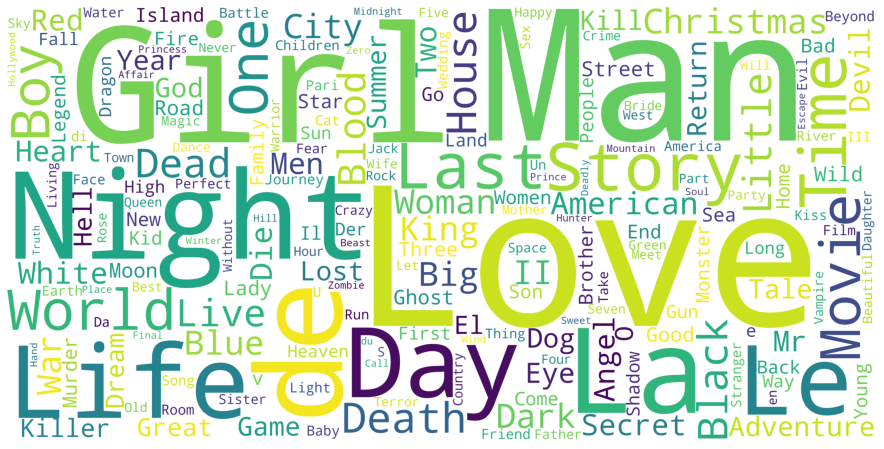

In [46]:
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(title_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

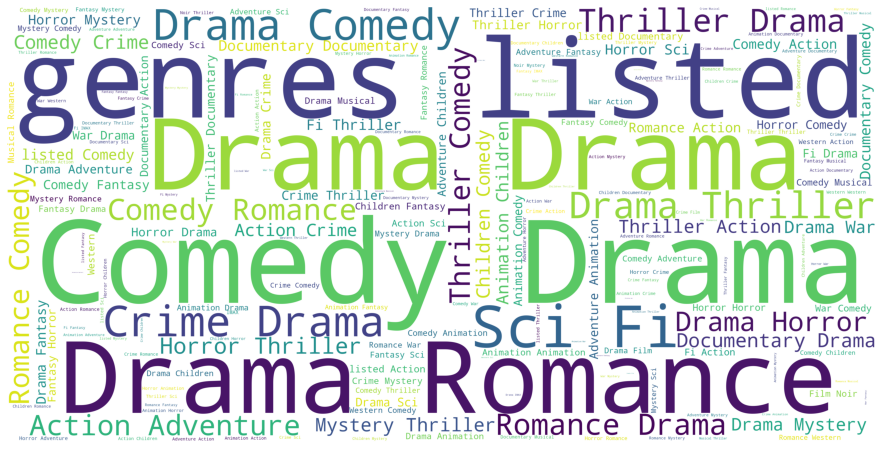

In [47]:
genres_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(genres_corpus)
plt.figure(figsize=(16,8))
plt.imshow(genres_wordcloud)
plt.axis('off')
plt.show()

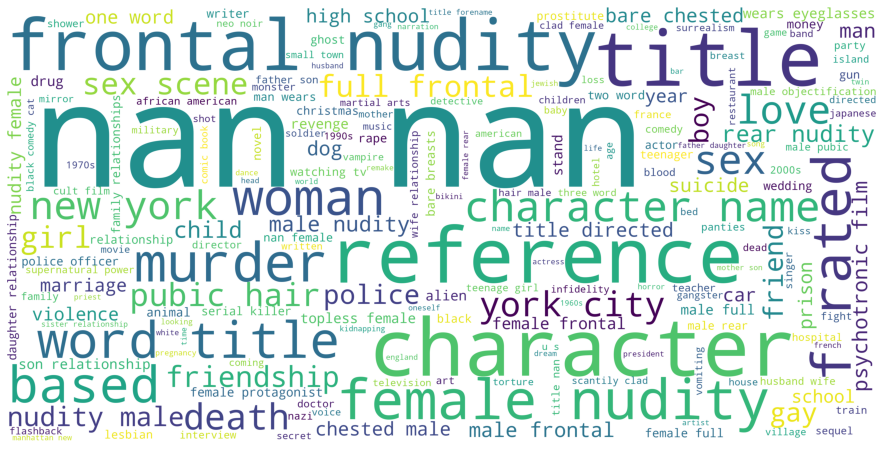

In [48]:
plot_keywords_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(plot_keywords_corpus)
plt.figure(figsize=(16,8))
plt.imshow(plot_keywords_wordcloud)
plt.axis('off')
plt.show()

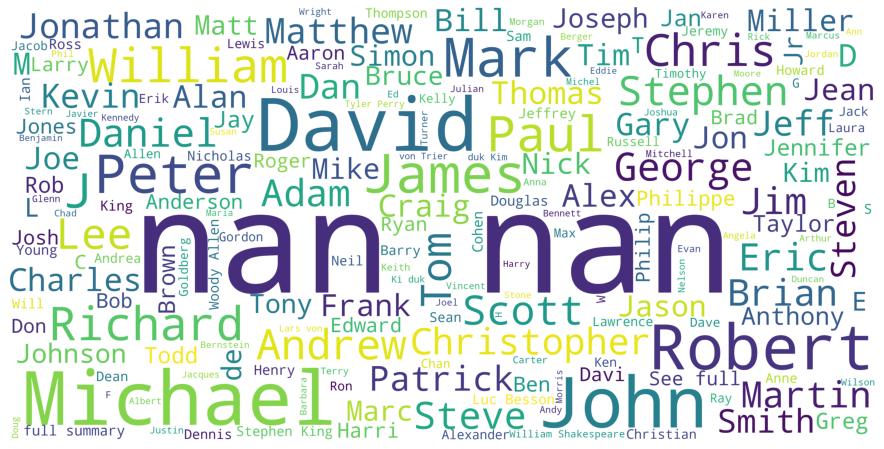

In [49]:
director_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(director_corpus)
plt.figure(figsize=(16,8))
plt.imshow(director_wordcloud)
plt.axis('off')
plt.show()

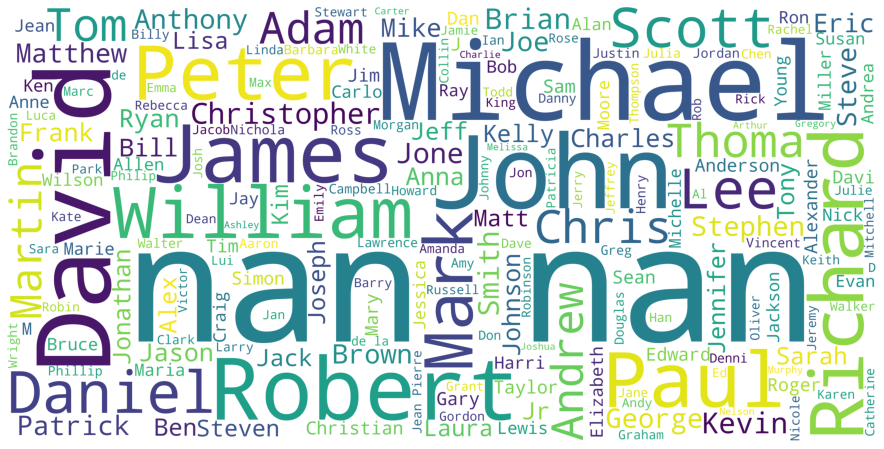

In [50]:
title_cast_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(title_cast_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_cast_wordcloud)
plt.axis('off')
plt.show()

#### iii) Rating

In [51]:
# Helper function to Change the numeric label in terms of Millions
def changingLabels(number):
    
    return str(number/10**6) + "M"

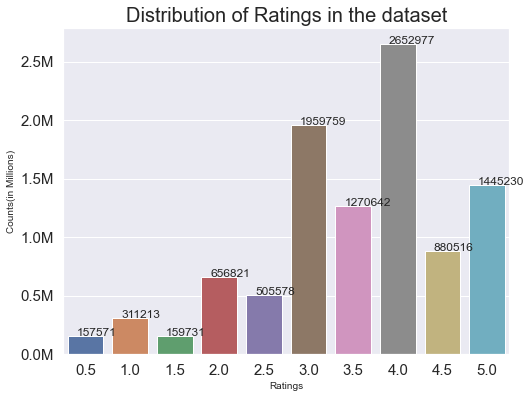

In [52]:
# Visualising the distribution of the feature "rating"

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(8, 6), sharey=True)

sns.countplot("rating", data=df_two, ax=axes)
axes.set_yticklabels([changingLabels(num) for num in axes.get_yticks()])
for p in axes.patches:
    axes.annotate('{}'.format(p.get_height()), (p.get_x()+0.2, p.get_height()+100))

plt.tick_params(labelsize = 15)
plt.title("Distribution of Ratings in the dataset", fontsize = 20)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Counts(in Millions)", fontsize = 10)
plt.show()

It is interesting that the ratings are left-skewed. It was expected that there would be a normal distrubtion with a mean rating of 3. Instead, we observe that users tend to rate movies quite favourably and tend to avoid negative ratings. This skew might be explained by the tendency of users to rate movies they liked. In other words, if a user doesn't like a movie, it is unlikely that they will watch it through to the end, let alone rate it.

#### Observations:

* The ratings given by users to movies lies in between 0.5 to 5.
* A high proportion of the movies have been rated 3, 3.5 or 4 by the users.
* The distribution of ratings look a bit left skewed as large proportion of ratings is in between 3 to 5.

Users that have rated the most movies:

In [53]:
def user_ratings_count(df_two, n):

    plt.figure(figsize=(8,6))
    data = df_two['userId'].value_counts().head(n)
    ax = sns.barplot(x = data.index, y = data, order= data.index)
    for p in ax.patches:
        axes.annotate('{}'.format(p.get_height()), (p.get_x()+0.2, p.get_height()+100))
    plt.title(f'Top {n} Users by Number of Ratings', fontsize=14)
    plt.xlabel('User ID')
    plt.ylabel('Number of Ratings')
    print("Combined number of ratings:\t",df_two['userId'].value_counts().head(n).sum(),
         "\nTotal number of movies:\t\t", df_two['movieId'].nunique())
    plt.show()

Combined number of ratings:	 34398 
Total number of movies:		 48213


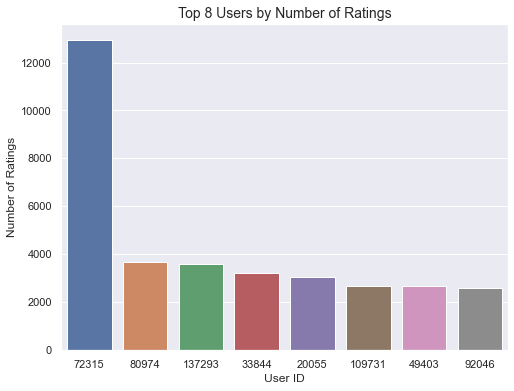

In [54]:
user_ratings_count(train_df,8)

In [55]:
# Exclude user 72315 for EDA
df_two_new = df_two[df_two['userId']!=72315]

KeyError: 'movieId'

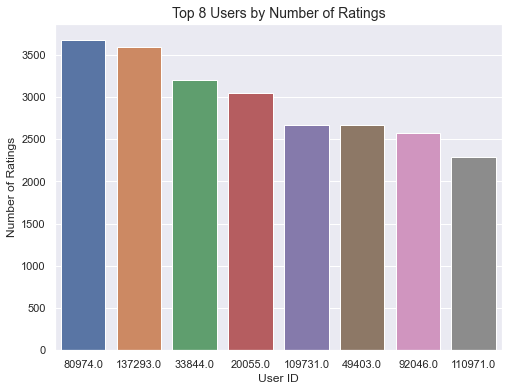

In [56]:
user_ratings_count(df_two_new,8)

    How do users tend to rate movies?

## 5. Feature Engineering

Feature engineering refers to a process of selecting and transforming variables/features in the dataset when creating a predictive model using machine learning. Therefore we have to extract the features from the raw dataset before training the model data in machine learning algorithms. 
Feature engineering has two goals: 

a) Preparing the proper input dataset, compatible with the machine learning algorithm            requirements 
         
b) Improving the performance of machine learning models.

### 5.1 Extracting year and genre

If we look at our movie dataset, we can see that every title in the title contains the release year of the movie. In this section we extract the year from the title column

In [57]:
movies_df.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


We firstly use regular expressions to find a year stored between parentheses so that we don't select movies that have years in their titles. we extract the year with the parentheses from the title to the new calumn 'year' as shown below.

In [58]:
#Using regular expressions to find a year stored between parentheses
#so that we don't select movies that have years in their titles
df_movies=movies_df
df_movies['year'] = df_movies.title.str.extract('(\(\d\d\d\d\))',expand=False)
df_movies.head(3)

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,(1995)
1,2,Jumanji (1995),Adventure|Children|Fantasy,(1995)
2,3,Grumpier Old Men (1995),Comedy|Romance,(1995)


Unfortunately, every entry in the year column have paratheses, so we are now removing them so that the year column can be numeric and the year inside will be a valid year

In [59]:
#Removing the parentheses
df_movies['year'] = df_movies.year.str.extract('(\d\d\d\d)',expand=False)
df_movies.head(3)

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995


In [60]:
#Removing the years from the 'title' column
df_movies['title'] = df_movies.title.str.replace('(\(\d\d\d\d\))', '')
df_movies.head(3)

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995


In [61]:
#Applying the strip function to get rid of any whitespace characters which might be at the end of a title
df_movies['title'] = df_movies['title'].apply(lambda x: x.strip())
df_movies.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


from the table above, the genre column has a veritcal bar |, so we remove it and create the list of the genre, as shown below

In [62]:
#Every genre is separated by a | so we call the split function on |
df_movies['genres'] = df_movies.genres.str.split('|')
df_movies.head(3)

,movieId,title,genres,year
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995


### 5.2 Removing missing values

We now check the missing values in our data, from the output of the code below, it is clear that only the year column have null or missing values

In [63]:
#Checking for missing values
df_movies.isna().sum()

movieId      0
title        0
genres       0
year       410
dtype: int64

Now the we fill all the missing values in the year column by 0 due to the fact that null values affects the performance of the model

In [64]:
# Filling in the missing values
df_movies.year.fillna(0, inplace=True)

### 5.3 reducing memory size

We check the computer memory occupied by the dataset, and the year is stored as an int64 but it has only four digit, so we convert it to int16 because the four digits can fit without any data loss.

In [65]:
#Checking for memory usage in the original movies dataframe
df_movies_original_mem = df_movies.memory_usage()
df_movies_original_mem

Index         128
movieId    499384
title      499384
genres     499384
year       499384
dtype: int64

In [66]:
# Let's save space by converting the year column from int64 to int16, since it holds a max of just 4 digits of numbers.
df_movies.year = df_movies.year.astype('int16')

## 5.4 feature engineering for content based filtering

Since we are building the content based and the collaborative based filtering system. These systems are built using different features, so in this section we focus on features required for building the content based filtering sytem.



##### 5.4.1 encoding genre

unlike the collaborative filtering algorithm, the content based requires the genre column  to be used. Since the genre column has many genres, we firstly encode all the genre to have their own column. if the movie is of a particular genre, the intersection of that movie and genere will have 1 or else the intersection will have 0.

In [67]:
# First let's make a copy of df_movies
movies_genres = df_movies.copy(deep=True)

# Let's iterate through df_movies, then append the movie genres as columns of 1s or 0s.
# 1 if that column contains movies in the genre at the present index and 0 if not.

x = []
for index, row in df_movies.iterrows():
    x.append(index)
    for genre in row['genres']:
        movies_genres.at[index, genre] = 1

# Confirm that every row has been iterated and acted upon
print(len(x) == len(df_movies))

#Let's inspect the dataframe
movies_genres.head(20)

True


,movieId,title,genres,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Grumpier Old Men,"[Comedy, Romance]",1995,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995,NaN,NaN,NaN,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Father of the Bride Part II,[Comedy],1995,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,Heat,"[Action, Crime, Thriller]",1995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,Sabrina,"[Comedy, Romance]",1995,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,Tom and Huck,"[Adventure, Children]",1995,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,Sudden Death,[Action],1995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,GoldenEye,"[Action, Adventure, Thriller]",1995,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Unfortunately, we have null values, so we fill these null values with a 0 indicating that the movie is not of that genre

In [68]:
#Filling in the NaN values with 0 to show that a movie doesn't have that column's genre
movies_genres = movies_genres.fillna(0)
movies_genres.head(3)

,movieId,title,genres,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men,"[Comedy, Romance]",1995,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 5.4.2 Inspecting the training dataset 

Looking at the training dataset in the output of the code below, we can see that we have thet timestamp feature, which is not required when building the content based model, so we are dropping the timestamp column.

In [69]:
# Renaming the training dataset to ratings
df_ratings = train_df.copy(deep=True)
#Checking the shape of the dataset
print('Ratings_df shape:',df_ratings.shape)          
#Inspecting the dataset
df_ratings.head()

Ratings_df shape: (10000038, 4)


,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [70]:
# Dropping the timestamp column
df_ratings.drop('timestamp', axis=1, inplace=True)

# Confirming the drop
df_ratings.head(3)

,userId,movieId,rating
0,5163,57669,4.0
1,106343,5,4.5
2,146790,5459,5.0


From the output of the code below, it is clear that the train dataset is of the correct data type, and it does not have nulls so we it is ready for modelling.

In [71]:
# Let's confirm the right data types exist per column in ratings data_set
df_ratings.dtypes

userId       int64
movieId      int64
rating     float64
dtype: object

In [72]:
# Let's check for missing values
df_ratings.isna().sum()

userId     0
movieId    0
rating     0
dtype: int64

## 5.5 Collaborative based method

#### 5.5.1 extracting date from timestamp column

Although the we don't need the timestamp for the content based filtering, for the collaborative we need it to extract the date from the timestamp.

In [73]:
# Converting the the UTC timestamp to Datetime to analyse the data based on the date
train_df["timestamp"] = train_df["timestamp"].apply(lambda x: datetime.utcfromtimestamp(x).strftime("%Y-%m-%d"))

we then merge movie dataset with the train dataset.

In [74]:
# Merging the movies and train_df data files for data analysis
movie_ratings = train_df.merge(df_movies, how="left", on="movieId")

In [75]:
movie_ratings.head(3)

,userId,movieId,rating,timestamp,title,genres,year
0,5163,57669,4.0,2018-02-11,In Bruges,"[Comedy, Crime, Drama, Thriller]",2008
1,106343,5,4.5,2008-03-23,Father of the Bride Part II,[Comedy],1995
2,146790,5459,5.0,2004-02-08,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2),"[Action, Comedy, Sci-Fi]",2002


if we look at the output obove we can rename the timestamp column to date because it is now holding the date data. the code below, rename the timestamp column to date 

In [76]:
# Renaming the timestamp to date
movie_ratings.rename(columns={"timestamp": "date"}, inplace=True)

In [77]:
# Sorting ratings based on date
movie_ratings.sort_values(by = "date", inplace = True)
movie_ratings.reset_index(drop=True, inplace=True)

In [78]:
# Checking the features and no. of records in the merged dataset

print("records:", movie_ratings.shape[0])
print("features: ", movie_ratings.shape[1])
print("The list of features is : ", movie_ratings.columns)
movie_ratings.head()

records: 10000038
features:  7
The list of features is :  Index(['userId', 'movieId', 'rating', 'date', 'title', 'genres', 'year'], dtype='object')


,userId,movieId,rating,date,title,genres,year
0,2262,47,5.0,1995-01-09,Seven (a.k.a. Se7en),"[Mystery, Thriller]",1995
1,109832,34,5.0,1996-01-29,Babe,"[Children, Drama]",1995
2,71732,19,1.0,1996-01-29,Ace Ventura: When Nature Calls,[Comedy],1995
3,102689,19,4.0,1996-01-29,Ace Ventura: When Nature Calls,[Comedy],1995
4,102689,58,5.0,1996-01-29,"Postman, The (Postino, Il)","[Comedy, Drama, Romance]",1994


#### 5.5.2 duplicates and nulls

Since the null values and duplicates affects the performance of the model, we check if our dataset have null values and duplicates; and from the output below, it is clear that there are no duplicates and null values.

In [79]:
# Check for null values in new merged dataframe
movie_ratings.isnull().sum()

userId     0
movieId    0
rating     0
date       0
title      0
genres     0
year       0
dtype: int64

In [80]:
# Checking for duplicates in the dataset
print("No. of duplicates records in the dataset : ", movie_ratings.columns.duplicated().sum())

No. of duplicates records in the dataset :  0


#### 5.5.4 adding more features for training

so we now add the imdb and the movie dataset because they have some features for building the model

In [81]:
# Merging the movies and train_df data files for data analysis
key_cast_ratings = train_df.merge(imdb_df, how="left", on="movieId")

In [82]:
key_cast_ratings.head(3)

,userId,movieId,rating,timestamp,title_cast,director,runtime,budget,plot_keywords
0,5163,57669,4.0,2018-02-11,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
1,106343,5,4.5,2008-03-23,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion
2,146790,5459,5.0,2004-02-08,Tommy Lee Jones|Will Smith|Rip Torn|Lara Flynn...,Lowell Cunningham,88.0,"$140,000,000",lingerie|michael jackson character|shorthaired...


In [83]:
eda_df = key_cast_ratings.merge(df_movies, how = 'left', on = 'movieId')

In [84]:
eda_df.head(3)

,userId,movieId,rating,timestamp,title_cast,director,runtime,budget,plot_keywords,title,genres,year
0,5163,57669,4.0,2018-02-11,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman,In Bruges,"[Comedy, Crime, Drama, Thriller]",2008
1,106343,5,4.5,2008-03-23,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion,Father of the Bride Part II,[Comedy],1995
2,146790,5459,5.0,2004-02-08,Tommy Lee Jones|Will Smith|Rip Torn|Lara Flynn...,Lowell Cunningham,88.0,"$140,000,000",lingerie|michael jackson character|shorthaired...,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2),"[Action, Comedy, Sci-Fi]",2002


#### 5.5.5 removing unnecessary features

we remove the runtime and the budget features bacause we don't need them that much and having more feature can slow down our model

In [85]:
EDA_Fin = eda_df.drop(['runtime', 'budget'], axis = 1)

In [86]:
EDA_Fin.head(3)

,userId,movieId,rating,timestamp,title_cast,director,plot_keywords,title,genres,year
0,5163,57669,4.0,2018-02-11,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,dwarf|bruges|irish|hitman,In Bruges,"[Comedy, Crime, Drama, Thriller]",2008
1,106343,5,4.5,2008-03-23,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,fatherhood|doberman|dog|mansion,Father of the Bride Part II,[Comedy],1995
2,146790,5459,5.0,2004-02-08,Tommy Lee Jones|Will Smith|Rip Torn|Lara Flynn...,Lowell Cunningham,lingerie|michael jackson character|shorthaired...,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2),"[Action, Comedy, Sci-Fi]",2002


from the output of the code below, we can see that there are no nulls in our marged dataset, so  it is now ready to be sent to the modelling phase.

In [87]:
cleaned_eda = EDA_Fin.dropna(axis = 0, how ='any')
cleaned_eda.isnull().sum()

userId           0
movieId          0
rating           0
timestamp        0
title_cast       0
director         0
plot_keywords    0
title            0
genres           0
year             0
dtype: int64

In [88]:
cleaned_eda.head(3)

,userId,movieId,rating,timestamp,title_cast,director,plot_keywords,title,genres,year
0,5163,57669,4.0,2018-02-11,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,dwarf|bruges|irish|hitman,In Bruges,"[Comedy, Crime, Drama, Thriller]",2008
1,106343,5,4.5,2008-03-23,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,fatherhood|doberman|dog|mansion,Father of the Bride Part II,[Comedy],1995
2,146790,5459,5.0,2004-02-08,Tommy Lee Jones|Will Smith|Rip Torn|Lara Flynn...,Lowell Cunningham,lingerie|michael jackson character|shorthaired...,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2),"[Action, Comedy, Sci-Fi]",2002
3,106362,32296,2.0,2015-02-04,Sandra Bullock|Regina King|Enrique Murciano|Wi...,Marc Lawrence,female protagonist|cleave gag|good woman|fbi,Miss Congeniality 2: Armed and Fabulous,"[Adventure, Comedy, Crime]",2005
4,9041,366,3.0,1996-05-29,Jeff Davis|Heather Langenkamp|Miko Hughes|Matt...,Wes Craven,freddy krueger|elm street|famous director as h...,Wes Craven's New Nightmare (Nightmare on Elm S...,"[Drama, Horror, Mystery, Thriller]",1994
...,...,...,...,...,...,...,...,...,...,...
10000033,136395,99114,5.0,2018-03-16,Jamie Foxx|Christoph Waltz|Leonardo DiCaprio|K...,Quentin Tarantino,racial vengeance|racial violence|historically ...,Django Unchained,"[Action, Drama, Western]",2012
10000034,140078,553,3.0,2001-10-08,Kurt Russell|Val Kilmer|Sam Elliott|Bill Paxto...,Kevin Jarre,wyatt earp character|two gun holster|double gu...,Tombstone,"[Action, Drama, Western]",1993
10000035,154807,56782,4.0,2008-11-26,Daniel Day-Lewis|Martin Stringer|Matthew Brade...,Paul Thomas Anderson,oil|misanthrope|loss of hearing|false prophet,There Will Be Blood,"[Drama, Western]",2007
10000036,85805,327,4.0,2016-11-23,Lori Petty|Ice-T|Naomi Watts|Don Harvey|Jeff K...,Alan Martin,desert|tank|21st century|2030s,Tank Girl,"[Action, Comedy, Sci-Fi]",1995


In [89]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/gudani/team-6-unsupervised-learning/86d0dfcc5a934a82b8c3dfe908f4b740
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     notebook            : 1
COMET INFO:     source_code         : 1
COMET INFO: ---------------------------
COMET INFO: Uploading metrics, params, and assets to Comet before program termination (may take several seconds)
COMET INFO: The Python SDK has 3600 seconds to finish before aborting...
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: All files uploaded, waiting for confirmation they have been all receive